<a href="https://colab.research.google.com/github/nightted/ML-LeeHongYi-HW/blob/master/HW5%20-%20Explainable%20AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime==0.1.1.37

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=1cca9f7888eb41831bd201b805f1ad93312e47a3b5736a67769047c862f72e81
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=3ff14ba35aa40898d5c2aa1642315a49797535ef7b1ad8a64b24e39e7df08045
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image 
import matplotlib.pyplot as plt
from lime import lime_image 
from skimage.segmentation import slic # for image 分割


# Pre-train Model Set

In [36]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        # out.size[0] dimension is the "size of dataset"
        # so this tensor shape is [size of data set , 512*4*4] 
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [37]:
# Prepare Pre-train model
best_model = Classifier()
best_model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/LeeHongYi HW/HW3 - CNN image Classifier/best_model.pt'))
best_model.cuda()

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [38]:
summary(best_model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         295,168
      BatchNorm2d-10          [-1, 256, 32, 32]             512
             ReLU-11          [-1, 256, 32, 32]               0
        MaxPool2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-14          [-1, 512,

# Data Pre-process

In [6]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip food-11.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  inflating: food-11/training/0_569.jpg  
  inflating: food-11/training/6_289.jpg  
  inflati

In [39]:
import os
class FoodDataSet(Dataset):
 
  def __init__(self,path=None):
 
    Img_path = './food-11'
    path = os.path.join(Img_path,'training')
    self.paths ,self.labels = self.get_path_label(path)    
    self.Transformer = transforms.Compose([
          transforms.Resize(size = (128,128)),
          transforms.ToTensor(),
    ])
 
  def get_path_label(self,path):
    all_imgs = sorted(os.listdir(path))
    img_paths = []
    img_labels = []
 
    for img_path in all_imgs:
      img_paths.append(os.path.join(path ,img_path))
      img_labels.append(int(img_path.split('_')[0]))
    return img_paths , img_labels
  
  def __len__(self):
    return len(self.paths)
 
  def __getitem__(self,index):

    X = Image.open(self.paths[index])
    X = self.Transformer(X) 
    Y = self.labels[index]

    return X ,Y

  def get_specific_pic(self,indices):

    select_pic = []
    select_label = []

    for idx in indices:
      
      X , Y = self.__getitem__(idx)
      select_pic.append(X)
      select_label.append(Y)
    return torch.stack(select_pic) , torch.tensor(select_label) # Torch.stack 將 [] 內 data 在 dim = 0 進行堆疊 , 組成一小 batch data .


In [40]:
train_set = FoodDataSet()
len(train_set)

9866

In [41]:

import matplotlib.pyplot as plt
class Saliency_Map():

    def __init__(self,train_set,model,number):
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define cuda
      self.model = model # model
      self.train_set = train_set # train_set
      self.select_number = number  # number of pic you want to select
      self.select_pic, self.select_label = train_set.get_specific_pic(self.random_pic(number))
      
    def random_pic(self,number):
        import random
        random_num = []
        for i in range(number):
          random_num.append(random.randint(1,self.train_set.__len__()))
        return random_num

    def saliency(self, select_pic = None , select_label = None ):

      def normalize(data):
        return (data - data.min()) / (data.max() - data.min())

      #Set model to eval mode
      self.model.eval()
      loss_fn = nn.CrossEntropyLoss()
      #Give input image a gradient trace & set cuda
      select_pic = self.select_pic
      select_pic = select_pic.to(self.device)
      select_label = self.select_label
      select_label = select_label.to(self.device )
      select_pic.requires_grad = True

      y_pred = self.model(select_pic)
      loss = loss_fn(y_pred,select_label)
      loss.backward()

      saliencys = select_pic.grad.abs().detach().cpu()
      saliencys = torch.stack([normalize(ele) for ele in saliencys]) # normalize

      return saliencys
    
    def plot_saliencys(self):

      saliencys = self.saliency()
      fig , axs = plt.subplots(2,self.select_number,figsize = (15,5))
      for row , target in enumerate([saliencys,self.select_pic]):
        for column , img in enumerate(target):
          axs[row][column].imshow(img.permute(1,2,0).numpy())
      
      plt.show()
      plt.close()




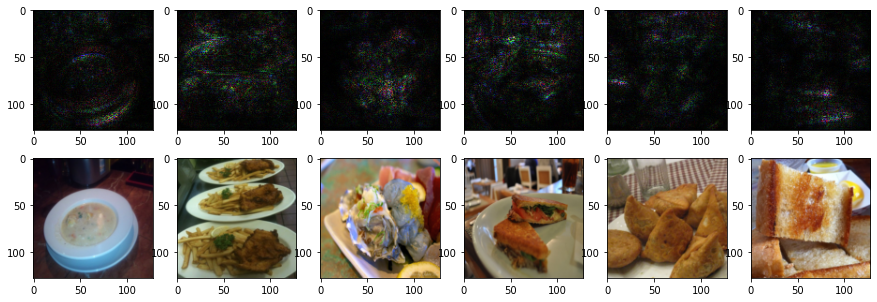

In [42]:
result = Saliency_Map(train_set,best_model,6)
result.plot_saliencys()

# Filter visualization

In [43]:
best_model.cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, s

In [160]:
 pics = [83,8598]
 x ,y  = train_set.get_specific_pic(pics)
 x

tensor([[[[0.2431, 0.2392, 0.2627,  ..., 0.3216, 0.3333, 0.3373],
          [0.2471, 0.2588, 0.2824,  ..., 0.3333, 0.3294, 0.3608],
          [0.2667, 0.2941, 0.3098,  ..., 0.3255, 0.3373, 0.3412],
          ...,
          [0.4039, 0.4078, 0.4157,  ..., 0.3333, 0.3451, 0.3412],
          [0.3961, 0.3961, 0.3961,  ..., 0.3373, 0.3373, 0.3216],
          [0.4039, 0.3804, 0.3843,  ..., 0.3294, 0.3451, 0.3255]],

         [[0.2039, 0.1961, 0.2157,  ..., 0.2353, 0.2471, 0.2510],
          [0.2000, 0.2157, 0.2471,  ..., 0.2471, 0.2431, 0.2745],
          [0.2157, 0.2549, 0.2824,  ..., 0.2392, 0.2510, 0.2549],
          ...,
          [0.2706, 0.2745, 0.2824,  ..., 0.2275, 0.2392, 0.2353],
          [0.2588, 0.2667, 0.2667,  ..., 0.2314, 0.2314, 0.2157],
          [0.2667, 0.2510, 0.2588,  ..., 0.2235, 0.2392, 0.2196]],

         [[0.1451, 0.1529, 0.1725,  ..., 0.1843, 0.1961, 0.2000],
          [0.1490, 0.1725, 0.2039,  ..., 0.1961, 0.1922, 0.2235],
          [0.1725, 0.2157, 0.2392,  ..., 0

In [161]:
def hook2(model,input,output):
  global z
  z = output
  
best_model.cnn[9].register_forward_hook(hook2)
best_model(x.cuda())
print("z:",z.shape)

z: torch.Size([2, 256, 32, 32])


IndexError: ignored

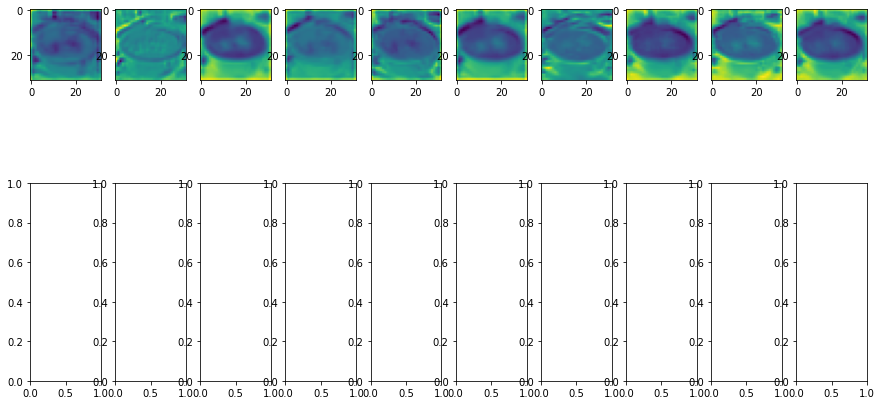

In [162]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

fig, axs = plt.subplots(2 ,10 , figsize=(15,8))
imgs = z.detach().cpu()
for i ,img in enumerate(imgs[1]):
  axs[0][i].imshow(normalize(img[:,:]))
for i ,img in enumerate(imgs[0]):
  axs[1][i].imshow(normalize(img[:,:]))
#for i ,img in enumerate(imgs):
#  for j , filters in enumerate(img):
#    axs[i][j].imshow(normalize(filters[:,:]))

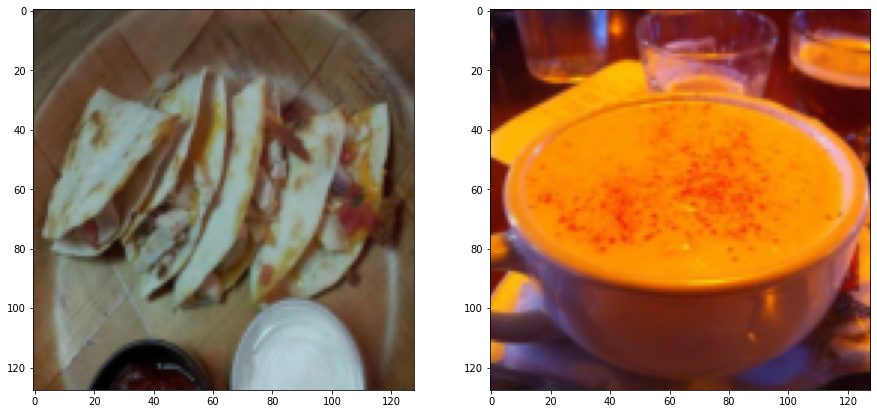

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

for i, img in enumerate(x): 
  axs[i].imshow(img.permute(1,2,0))

In [226]:
x_data = x.cuda()
x_data.requires_grad = True
optimizier = torch.optim.Adam([x_data],lr = 0.01)
x_data.requires_grad

True

In [227]:
def hook0(model,input,output):
  global g
  g = output
  
hook_record = best_model.cnn[8].register_forward_hook(hook0)

torch.Size([2, 3, 128, 128])
This is filter108: for image 0


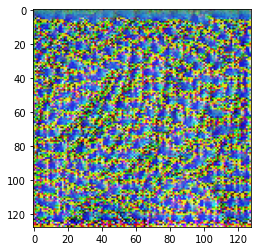

This is filter108: for image 1


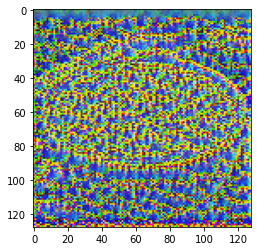

torch.Size([2, 3, 128, 128])
This is filter109: for image 0


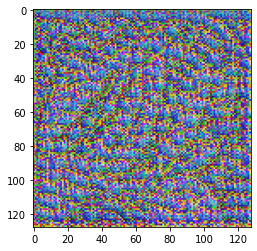

This is filter109: for image 1


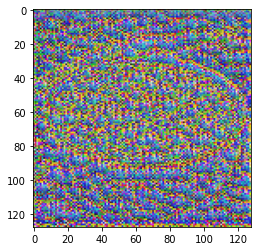

torch.Size([2, 3, 128, 128])
This is filter110: for image 0


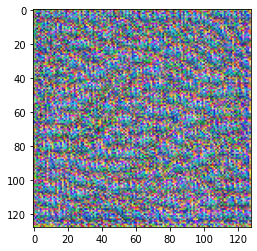

This is filter110: for image 1


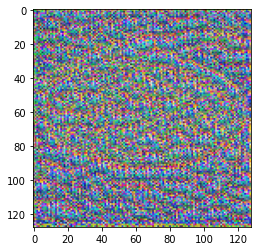

torch.Size([2, 3, 128, 128])
This is filter111: for image 0


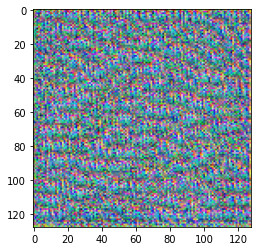

This is filter111: for image 1


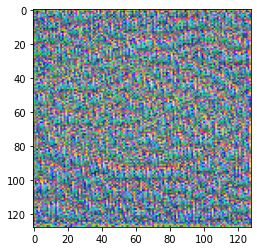

torch.Size([2, 3, 128, 128])
This is filter112: for image 0


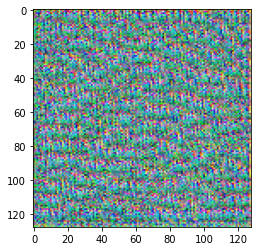

This is filter112: for image 1


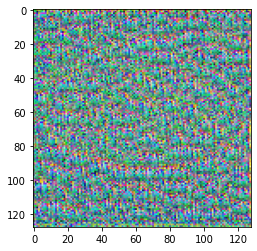

torch.Size([2, 3, 128, 128])
This is filter113: for image 0


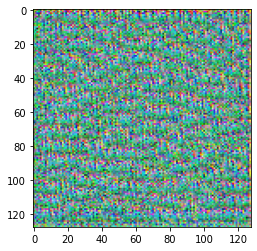

This is filter113: for image 1


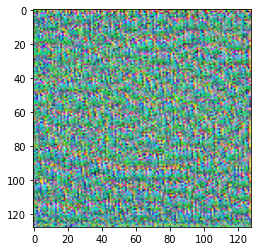

torch.Size([2, 3, 128, 128])
This is filter114: for image 0


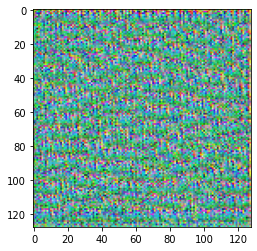

This is filter114: for image 1


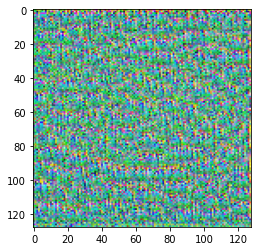

In [228]:
iteration = 200
filter = list(range(108,115))
for filter in filter:
  for iter in range(iteration):
    best_model.eval()
    best_model(x_data)
    loss = -1*g[:,filter,:,:].sum() # Max -> Min
    loss.backward()
    optimizier.step()

  visualization = x_data.detach().cpu()
  print(visualization.shape)
  #print(normalize(visualization.permute(1,2,0)))
  hook_record.remove()
  # 很重要!! ：一旦對 model register hook，該 hook 就一直存在。如果之後繼續 register 更多 hook
  # 那 model 一次 forward 要做的事情就越來越多，甚至其行為模式會超出你預期 (因為你忘記哪邊有用不到的 hook 了)
  # 因此事情做完了之後，就把這個 hook 拿掉，下次想要再做事時再 register 就好了。
  for i, img in enumerate(visualization):
    print("This is filter{}: for image {}".format(filter,i))
    plt.imshow(normalize(img.permute(1,2,0)))
    plt.show()
    plt.close()




range(1, 6)